In [ ]:
###########################################################
# GPU Configuration and Environment Setup
###########################################################
import tensorflow as tf
from tensorflow.keras import backend as K

# Detect and configure GPUs
print("=" * 60)
print("TensorFlow Environment")
print("=" * 60)
print(f"TensorFlow version: {tf.__version__}")
print(f"Built with CUDA: {tf.test.is_built_with_cuda()}")

# List available devices
gpus = tf.config.list_physical_devices('GPU')
cpus = tf.config.list_physical_devices('CPU')
print(f"CPUs available: {len(cpus)}")
print(f"GPUs available: {len(gpus)}")

if gpus:
    print("\nGPU Details:")
    for i, gpu in enumerate(gpus):
        print(f"  [{i}] {gpu.name}")
    
    # Enable memory growth to prevent OOM on shared systems
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
            print(f"\n✓ Memory growth enabled for {gpu.name}")
        except RuntimeError as e:
            print(f"✗ Could not set memory growth: {e}")
    
    # Optionally limit to single GPU (uncomment if needed)
    # tf.config.set_visible_devices(gpus[0], 'GPU')
    
    print("\n✓ GPU acceleration ENABLED")
else:
    print("\n⚠ No GPU detected - running on CPU")
    print("  For GPU support, ensure CUDA and cuDNN are installed")

print("=" * 60)

###########################################################
# Standard imports
###########################################################
import datetime
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from utils_3D import c, w, cs2, Q, compute_feq, rmsre

In [2]:
# set precision (default is 'float32')
K.set_floatx('float64')

In [3]:
###########################################################
# O_h Symmetry Group for D3Q19 (48 transformations)
# Must match the training notebook implementation exactly
###########################################################

from utils_3D import c as D3Q19_STENCIL

def _find_permutation(transform_matrix, stencil):
    """Compute index permutation from transformation matrix."""
    transformed = (transform_matrix @ stencil.T).T
    perm = []
    for vec in transformed:
        for j, orig_vec in enumerate(stencil):
            if np.allclose(vec, orig_vec):
                perm.append(j)
                break
    return perm

def _generate_rotation_matrices():
    """Generate 24 rotation matrices of the cube via BFS."""
    Rx = np.array([[1, 0, 0], [0, 0, -1], [0, 1, 0]], dtype=np.float64)
    Ry = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]], dtype=np.float64)
    Rz = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]], dtype=np.float64)
    
    I = np.eye(3, dtype=np.float64)
    rotations = [I]
    visited = {tuple(I.flatten())}
    queue = [I]
    
    while queue:
        current = queue.pop(0)
        for gen in [Rx, Ry, Rz]:
            new_rot = current @ gen
            key = tuple(np.round(new_rot, 10).flatten())
            if key not in visited:
                visited.add(key)
                rotations.append(new_rot)
                queue.append(new_rot)
    return rotations

def _generate_Oh_transforms():
    """Generate all 48 O_h symmetry transformations."""
    rotations = _generate_rotation_matrices()
    inversion = -np.eye(3, dtype=np.float64)
    transforms = []
    for R in rotations:
        transforms.append(R)
    for R in rotations:
        transforms.append(inversion @ R)
    return transforms

# Generate permutations
_OH_TRANSFORMS = _generate_Oh_transforms()
_OH_PERMS = [_find_permutation(T, D3Q19_STENCIL) for T in _OH_TRANSFORMS]
_OH_INV_PERMS = [[perm.index(i) for i in range(19)] for perm in _OH_PERMS]


class OhSymmetry(tf.keras.layers.Layer):
    """Apply all 48 O_h symmetry operations to D3Q19 distributions."""
    def __init__(self, **kwargs):
        super(OhSymmetry, self).__init__(**kwargs)
        self.perms = [tf.constant(p, dtype=tf.int32) for p in _OH_PERMS]

    def call(self, x):
        return [tf.gather(x, perm, axis=-1) for perm in self.perms]


class OhAntiSymmetry(tf.keras.layers.Layer):
    """Apply inverse O_h symmetry operations."""
    def __init__(self, **kwargs):
        super(OhAntiSymmetry, self).__init__(**kwargs)
        self.inv_perms = [tf.constant(p, dtype=tf.int32) for p in _OH_INV_PERMS]

    def call(self, x):
        return [tf.gather(x[i], self.inv_perms[i], axis=-1) for i in range(48)]


class AlgReconstruction3D(tf.keras.layers.Layer):
    """Algebraic reconstruction for D3Q19 conservation laws."""
    def __init__(self, **kwargs):
        super(AlgReconstruction3D, self).__init__(**kwargs)

    def call(self, fpre, fpred):
        df = fpred - fpre
        
        df1_new = (df[:,2] - df[:,7] - df[:,8] + df[:,9] + df[:,10] 
                   - df[:,15] - df[:,16] + df[:,17] + df[:,18])
        df3_new = (df[:,4] - df[:,7] + df[:,8] - df[:,9] + df[:,10] 
                   - df[:,11] - df[:,12] + df[:,13] + df[:,14])
        df5_new = (df[:,6] - df[:,11] + df[:,12] - df[:,13] + df[:,14] 
                   - df[:,15] + df[:,16] - df[:,17] + df[:,18])
        df0_new = (-2.0*df[:,2] - 2.0*df[:,4] - 2.0*df[:,6] 
                   + df[:,7] - df[:,8] - df[:,9] - 3.0*df[:,10]
                   + df[:,11] - df[:,12] - df[:,13] - 3.0*df[:,14]
                   + df[:,15] - df[:,16] - df[:,17] - 3.0*df[:,18])
        
        df_reconstructed = tf.concat([
            df0_new[:, None], df1_new[:, None], df[:, 2, None],
            df3_new[:, None], df[:, 4, None], df5_new[:, None], df[:, 6, None],
            df[:, 7, None], df[:, 8, None], df[:, 9, None], df[:, 10, None],
            df[:, 11, None], df[:, 12, None], df[:, 13, None], df[:, 14, None],
            df[:, 15, None], df[:, 16, None], df[:, 17, None], df[:, 18, None],
        ], axis=-1)
        
        return fpre + df_reconstructed

In [4]:
##########################################################
# Import trained 3D model from file

model = tf.keras.models.load_model("example_network_3D.keras", 
                                   custom_objects = {
                                        'rmsre': rmsre,
                                        'OhSymmetry': OhSymmetry,
                                        'OhAntiSymmetry': OhAntiSymmetry,
                                        'AlgReconstruction3D': AlgReconstruction3D
                                    }
                                  )

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 19)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ oh_symmetry         │ [(None, 19),      │          0 │ input_layer[0][0] │
│ (OhSymmetry)        │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                 

 Total params: 20,702 (161.73 KB)

 Trainable params: 6,900 (53.91 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,802 (107.83 KB)

In [ ]:
###########################################################
# Simulation Parameters
#
# For supercomputer runs, increase grid size and iterations.
# Memory estimate: ~8 bytes * nx * ny * nz * Q * 2 (for f1, f2)
#   32^3:  ~100 MB
#   64^3:  ~800 MB  
#   128^3: ~6.4 GB
###########################################################

# Grid size (increase for production runs)
nx      = 32   # grid size along x
ny      = 32   # grid size along y
nz      = 32   # grid size along z

# Time stepping
niter   = 1000  # total number of steps
dumpit  = 100   # collect data every dumpit iterations

# Physical parameters
tau     = 0.8   # relaxation time (lower = less viscosity, slower decay)
u0      = 0.01  # initial velocity amplitude

# Inference settings
verbose = 0     # 0 = silent, 1 = progress bar per batch
batch_size_inference = None  # None = process all at once, or set explicitly

###########################################################
# Compute derived quantities
###########################################################
ncells = nx * ny * nz
nu = (tau - 0.5) * cs2  # kinematic viscosity

print(f"3D Grid: {nx} x {ny} x {nz} = {ncells:,} cells")
print(f"D3Q19 lattice: {Q} velocities per cell")
print(f"Total DOF: {ncells * Q:,}")
print(f"Estimated memory: {ncells * Q * 8 * 2 / 1e6:.1f} MB")
print(f"\nPhysics:")
print(f"  tau = {tau}, nu = {nu:.4f}")
print(f"  Decay time constant: {(nx / (2*np.pi))**2 / (2*nu):.1f} timesteps")

In [ ]:
###########################################################
# Data collection for 3D simulation
# Store: time, rho, ux, uy, uz for each cell
#
# Note: For very large grids, consider saving to disk incrementally
# instead of storing all timesteps in memory.
###########################################################

ndumps = int(niter // dumpit)

# Estimate memory for dumpfile
dumpfile_memory_mb = ndumps * ncells * 5 * 8 / 1e6
print(f"Data collection: {ndumps} dumps × {ncells:,} cells × 5 fields")
print(f"Dumpfile memory: {dumpfile_memory_mb:.1f} MB")

if dumpfile_memory_mb > 1000:
    print(f"⚠ Warning: Large dumpfile ({dumpfile_memory_mb:.0f} MB). Consider reducing dumpit or grid size.")

dumpfile = np.zeros((ndumps * ncells, 5), dtype=np.float64)


def data_collector(dumpfile, t, ux, uy, uz, rho):
    """Store simulation state at time t."""
    it   = t // dumpit
    idx0 = it * ncells
    idx1 = (it + 1) * ncells
    dumpfile[idx0:idx1, 0] = t
    dumpfile[idx0:idx1, 1] = rho.reshape(ncells)
    dumpfile[idx0:idx1, 2] = ux.reshape(ncells)
    dumpfile[idx0:idx1, 3] = uy.reshape(ncells)
    dumpfile[idx0:idx1, 4] = uz.reshape(ncells)

In [7]:
##########################################################
# Set Initial conditions: 3D Taylor-Green Vortex
#
# The 3D Taylor-Green vortex is a canonical test case with 
# known analytical behavior for the kinetic energy decay.
#
# Initial velocity field:
#   ux =  u0 * sin(x) * cos(y) * cos(z)
#   uy = -u0 * cos(x) * sin(y) * cos(z)
#   uz = 0
#
# Reference: Taylor & Green (1937), Wikipedia
##########################################################

# Wavenumbers
a = b = d = 1.0

# Create 3D meshgrid
ix, iy, iz = np.meshgrid(range(nx), range(ny), range(nz), indexing='ij')

x = 2.0 * np.pi * (ix / nx)
y = 2.0 * np.pi * (iy / ny)
z = 2.0 * np.pi * (iz / nz)

# 3D Taylor-Green vortex initial conditions
ux =  u0 * np.sin(a * x) * np.cos(b * y) * np.cos(d * z)
uy = -u0 * np.cos(a * x) * np.sin(b * y) * np.cos(d * z)
uz =  np.zeros_like(ux)  # uz = 0 for standard TG vortex

# Uniform density
rho = np.ones((nx, ny, nz))

###########################################################
# Initialize lattice distributions at equilibrium
feq = np.zeros((nx, ny, nz, Q))
feq = compute_feq(feq, rho, ux, uy, uz)

f1 = np.copy(feq)
f2 = np.copy(feq)

print(f"Initial velocity magnitude: max|u| = {np.max(np.sqrt(ux**2 + uy**2 + uz**2)):.4f}")
print(f"Mach number: Ma = {u0 / np.sqrt(cs2):.4f}")

Initial velocity magnitude: max|u| = 0.0100
Mach number: Ma = 0.0173


In [ ]:
###########################################################
# Main simulation loop for 3D LBM with ML collision operator
#
# Optimizations for GPU/supercomputer:
# - Use model(x) instead of model.predict(x) for small batches
# - Preallocate arrays to avoid memory allocation overhead
# - Use tf.function for GPU-optimized inference (optional)
###########################################################

# Collect initial state
data_collector(dumpfile, 0, ux, uy, uz, rho)

# Store initial mass for conservation check
m_initial = np.sum(f1.flatten())

###########################################################
# Create optimized prediction function
###########################################################
@tf.function(reduce_retracing=True)
def predict_collision(fpre_tensor):
    """GPU-optimized collision prediction."""
    return model(fpre_tensor, training=False)

# Warm-up call to compile the tf.function
_ = predict_collision(tf.constant(f1.reshape((ncells, Q)) / np.sum(f1.reshape((ncells, Q)), axis=1, keepdims=True), dtype=tf.float64))
print("✓ Prediction function compiled")

###########################################################
# Time stepping loop
###########################################################
print(f"\nStarting 3D simulation ({niter} iterations)...")
import time
start_time = time.time()

for t in range(1, niter):
    
    # Streaming step: shift distributions along velocity directions
    for ip in range(Q):
        f1[:, :, :, ip] = np.roll(
            np.roll(
                np.roll(f2[:, :, :, ip], c[ip, 0], axis=0),
                c[ip, 1], axis=1),
            c[ip, 2], axis=2)

    # Calculate macroscopic density: rho = sum(f)
    rho = np.sum(f1, axis=3)

    # Calculate macroscopic velocity: u = (1/rho) * sum(f * c)
    ux = (1.0 / rho) * np.einsum('ijkl,l', f1, c[:, 0])
    uy = (1.0 / rho) * np.einsum('ijkl,l', f1, c[:, 1])
    uz = (1.0 / rho) * np.einsum('ijkl,l', f1, c[:, 2])

    #########################################
    # ML collision step (GPU-optimized)
    #########################################
    
    # Flatten and normalize
    fpre = f1.reshape((ncells, Q))
    norm = np.sum(fpre, axis=1, keepdims=True)
    fpre_normalized = fpre / norm

    # GPU prediction using compiled function
    fpre_tensor = tf.constant(fpre_normalized, dtype=tf.float64)
    f2_normalized = predict_collision(fpre_tensor).numpy()

    # Rescale and reshape
    f2 = norm * f2_normalized
    f2 = f2.reshape((nx, ny, nz, Q))
    
    #########################################
    
    # Collect data and progress report
    if (t % dumpit) == 0:
        data_collector(dumpfile, t, ux, uy, uz, rho)
        elapsed = time.time() - start_time
        steps_per_sec = t / elapsed
        eta = (niter - t) / steps_per_sec
        print(f"  t = {t:5d}/{niter} | {elapsed:6.1f}s elapsed | {steps_per_sec:.1f} steps/s | ETA: {eta:.0f}s")

# Final statistics
m_final = np.sum(f2.flatten())
mass_err = np.abs(m_initial - m_final) / m_initial
elapsed_total = time.time() - start_time

print(f"\n{'='*60}")
print(f"Simulation complete!")
print(f"  Total time: {elapsed_total:.1f}s ({niter/elapsed_total:.1f} steps/s)")
print(f"  Mass conservation error: {mass_err:.2e}")
print(f"{'='*60}")

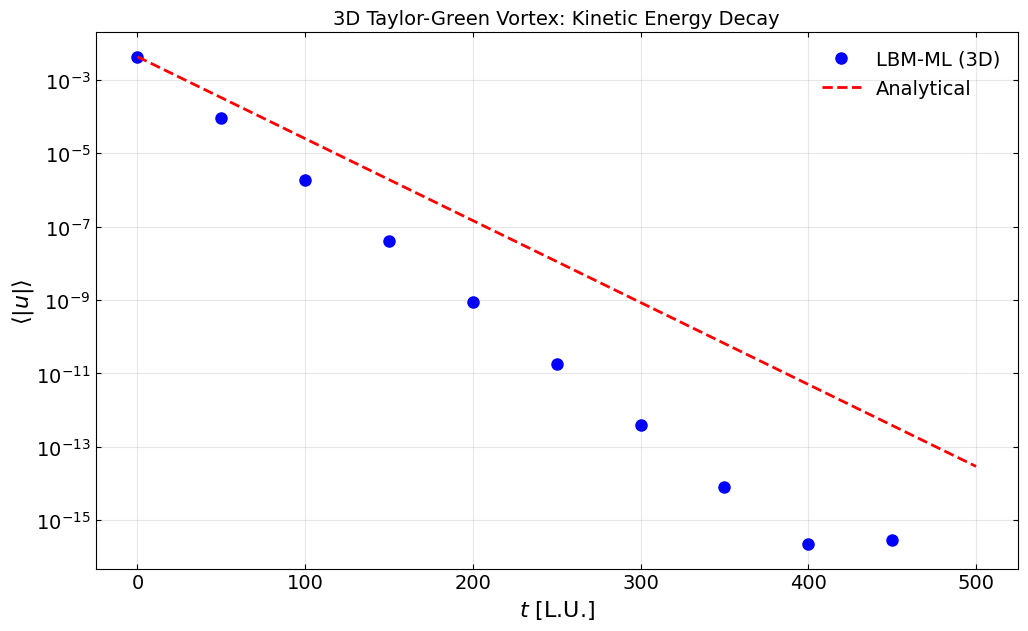


Simulation parameters:
  Relaxation time tau = 1.0
  Kinematic viscosity nu = 0.1667
  Grid size L = 16


In [9]:
###########################################################
# Energy decay analysis for 3D Taylor-Green vortex
#
# The kinetic energy should decay exponentially:
#   E(t) = E0 * exp(-2*nu*t / (L/(2*pi))^2)
# where nu = (tau - 0.5) * cs2 is the kinematic viscosity
###########################################################

w_fig = 3.46 * 3
h_fig = 2.14 * 3

def analytical_decay(t, L, E0, nu):
    """Analytical solution for kinetic energy decay."""
    return E0 * np.exp(-2 * nu * t / (L / (2 * np.pi))**2)

###################################################################

fig = plt.figure(figsize=(w_fig, h_fig))
ax = fig.add_subplot(111)

tLst = np.arange(0, niter, dumpit)

# Compute kinetic energy at each timestep
for i, t in enumerate(tLst):
    ux_t = dumpfile[dumpfile[:, 0] == t, 2]
    uy_t = dumpfile[dumpfile[:, 0] == t, 3]
    uz_t = dumpfile[dumpfile[:, 0] == t, 4]
    
    # Mean velocity magnitude (kinetic energy proxy)
    Et = np.mean(np.sqrt(ux_t**2 + uy_t**2 + uz_t**2))
    
    if i == 0:
        E0 = Et
        ax.semilogy(t, Et, 'ob', markersize=8, label='LBM-ML (3D)')
    else:
        ax.semilogy(t, Et, 'ob', markersize=8)

# Kinematic viscosity from relaxation time
nu = (tau - 0.5) * cs2

# Plot analytical solution
t_analytical = np.linspace(0, niter, 100)
ax.semilogy(t_analytical, analytical_decay(t_analytical, nx, E0, nu), 
            linewidth=2.0, linestyle='--', color='r', label='Analytical')

###################################################################

ax.set_xlabel(r'$t$ [L.U.]', fontsize=16)
ax.set_ylabel(r'$\langle |u| \rangle$', fontsize=16, rotation=90, labelpad=0)
ax.set_title('3D Taylor-Green Vortex: Kinetic Energy Decay', fontsize=14)

ax.legend(loc='best', frameon=False, prop={'size': 14})
ax.tick_params(which="both", direction="in", top=True, right=True, labelsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print viscosity info
print(f"\nSimulation parameters:")
print(f"  Relaxation time tau = {tau}")
print(f"  Kinematic viscosity nu = {nu:.4f}")
print(f"  Grid size L = {nx}")

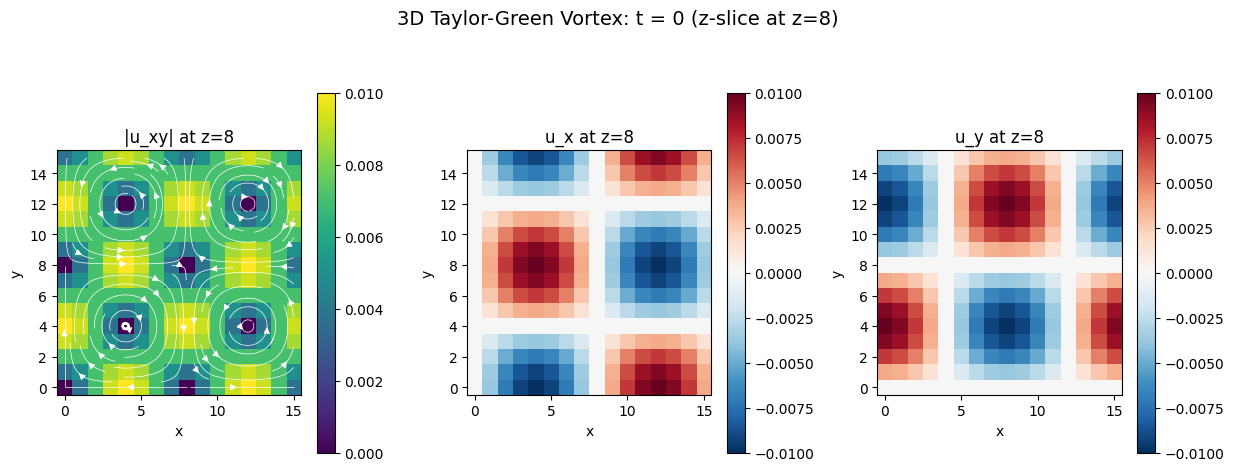

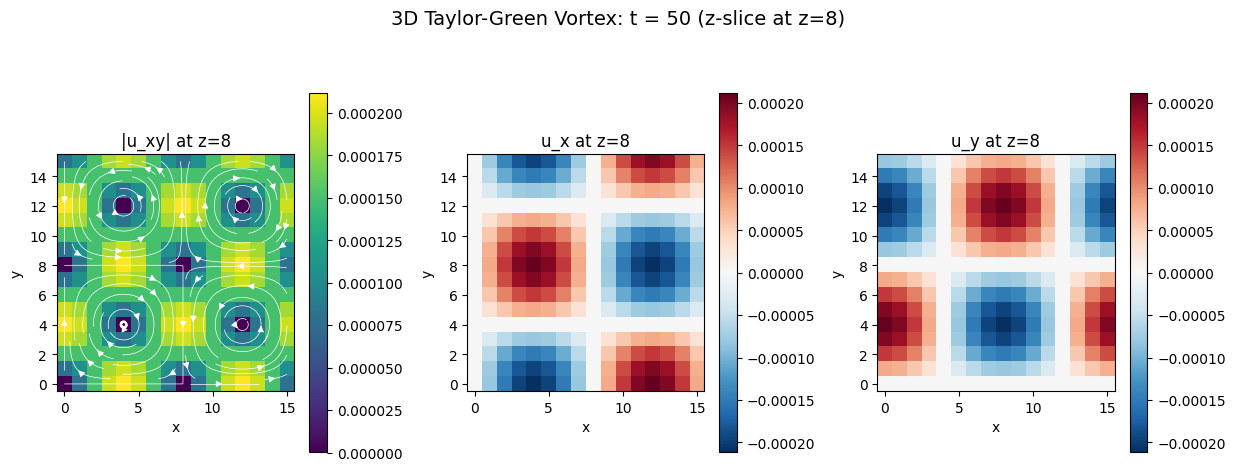

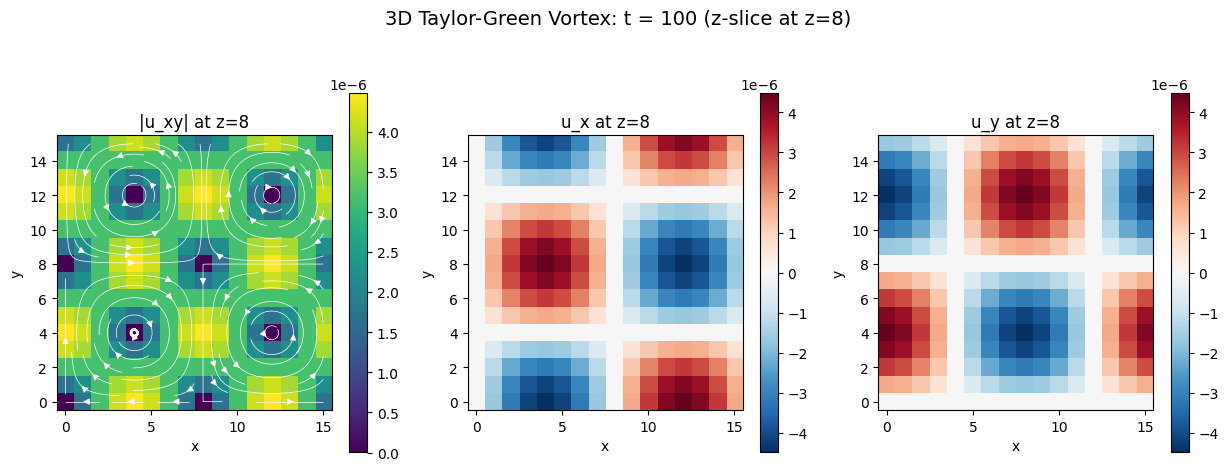

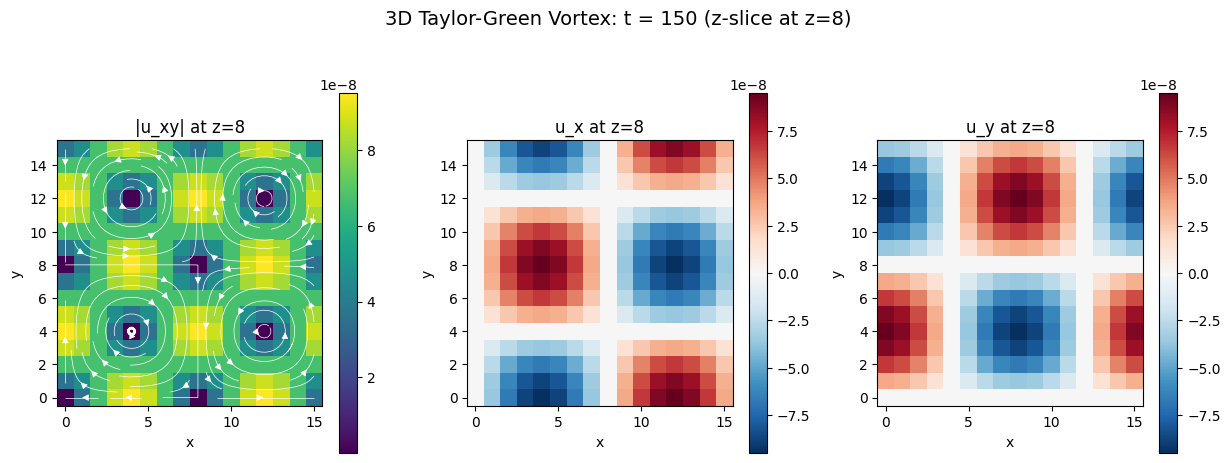

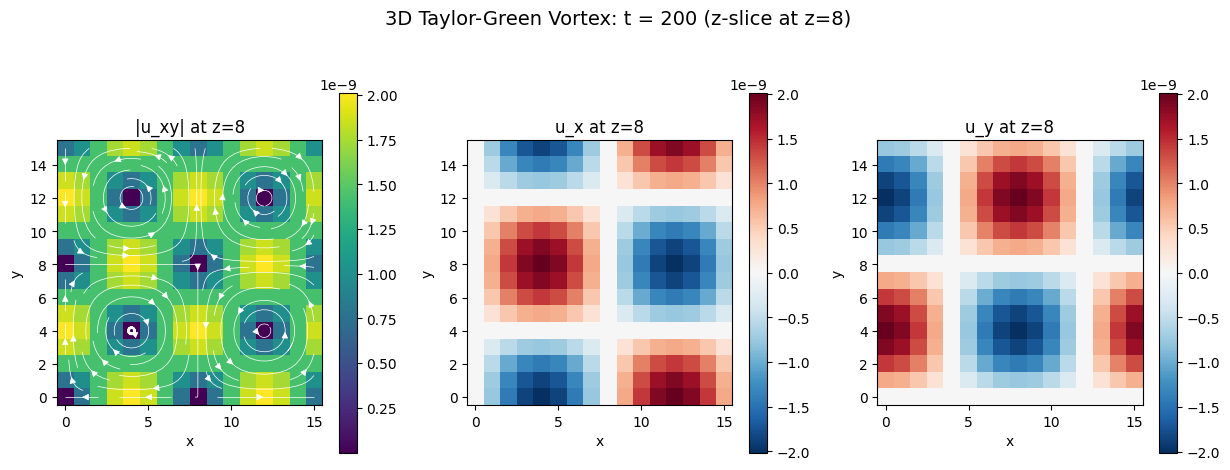

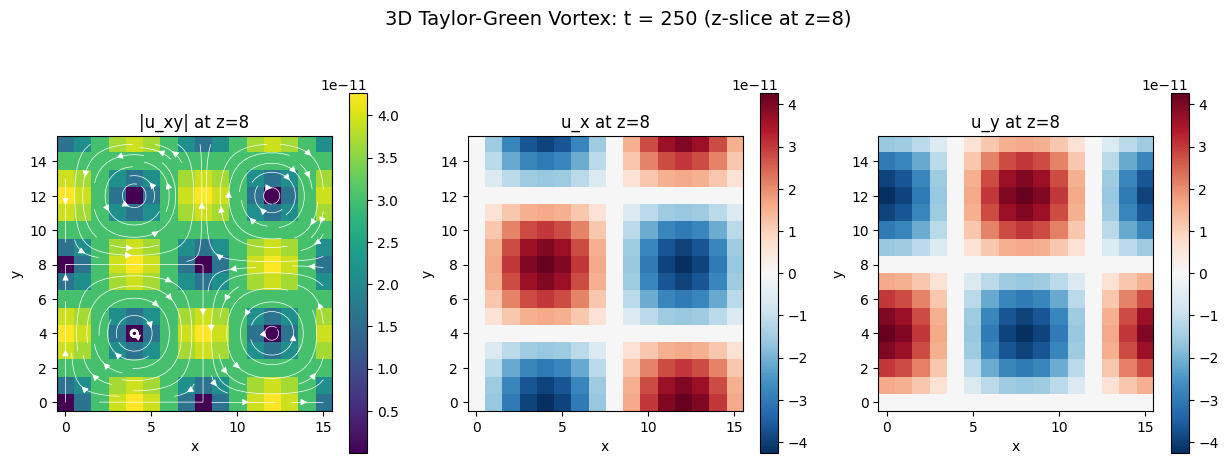

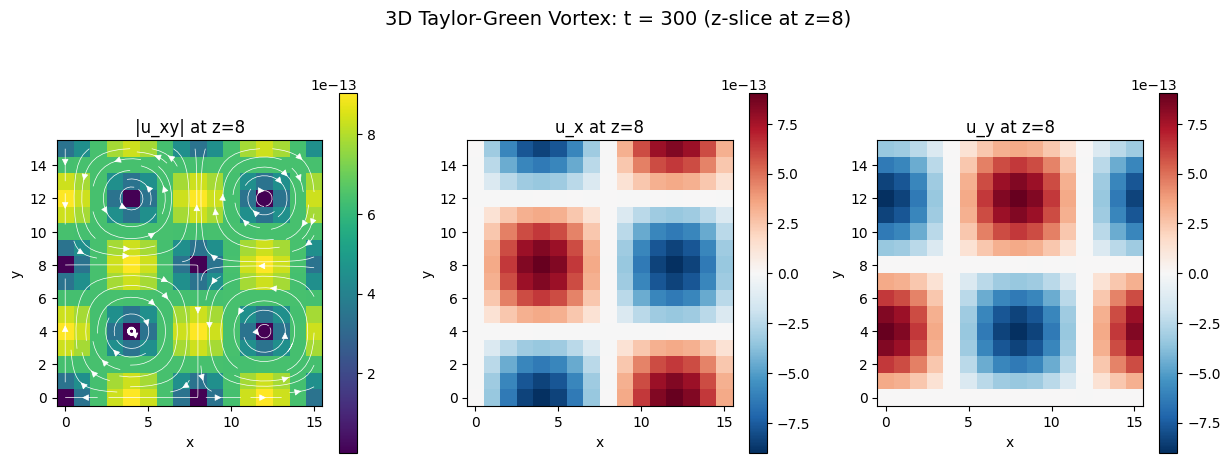

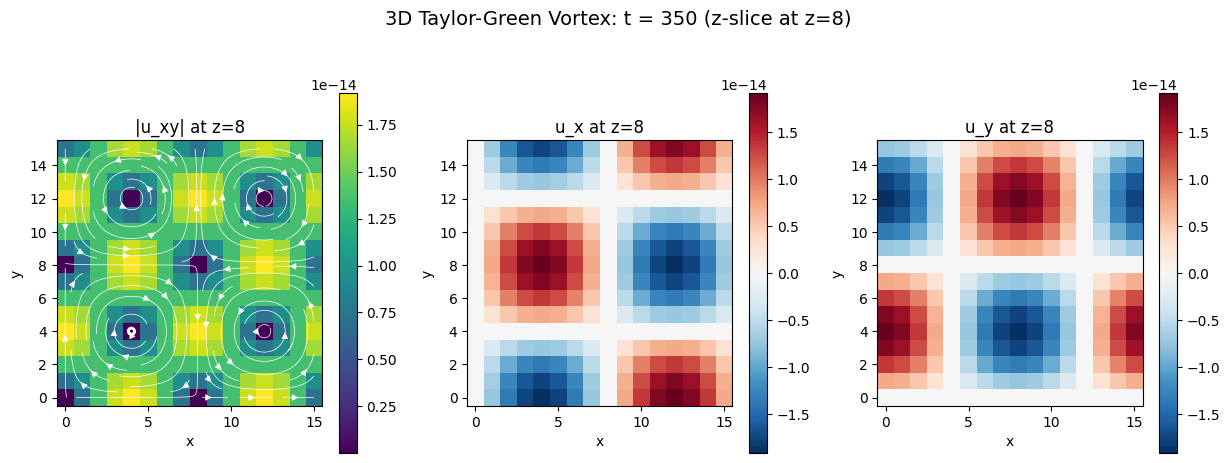

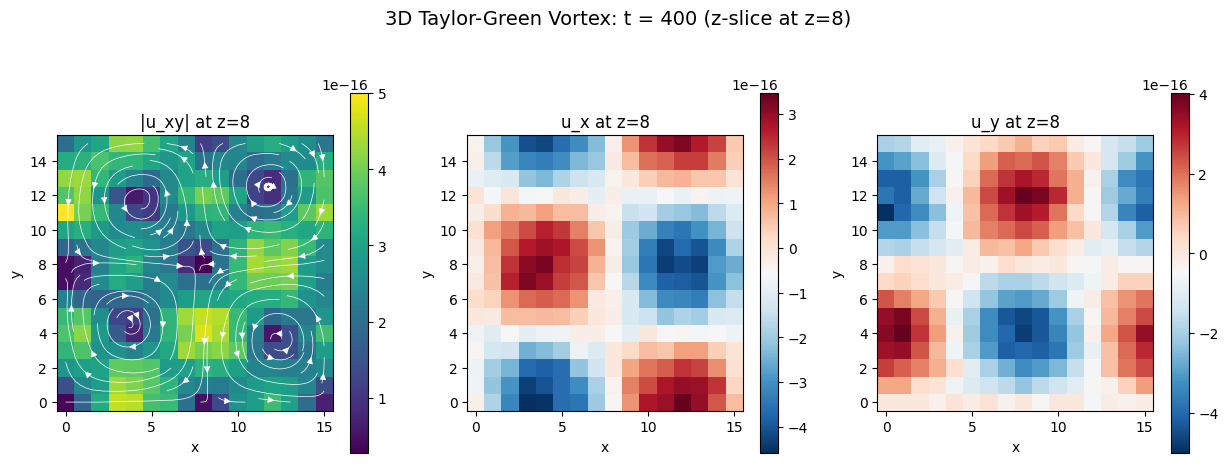

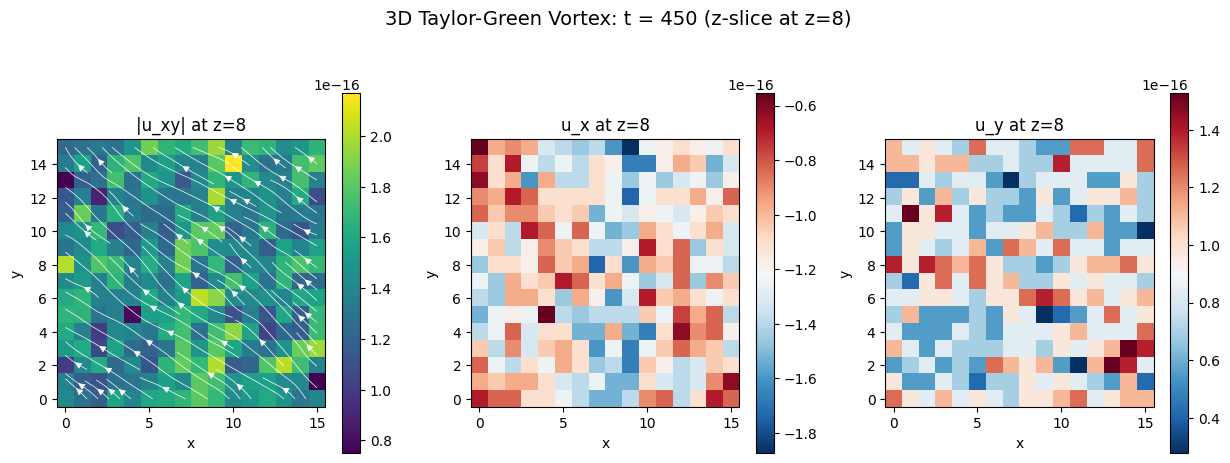

In [10]:
###########################################################
# 3D Visualization: Velocity field slices
#
# For 3D flow fields, we visualize 2D slices through the domain.
# We show the xy-plane at z=0 (midplane for periodic BC).
###########################################################

w_fig = 3.46 * 3
h_fig = 2.14 * 3

# Select z-slice for visualization (middle of domain)
z_slice = nz // 2

# Meshgrid for streamplot
X, Y = np.meshgrid(np.arange(0, nx), np.arange(0, ny), indexing='ij')

tLst = np.arange(0, niter, dumpit)

for i, t in enumerate(tLst):
    fig, axes = plt.subplots(1, 3, figsize=(w_fig * 1.2, h_fig * 0.8))
    
    # Reshape velocity fields from dumpfile
    ux_3d = dumpfile[dumpfile[:, 0] == t, 2].reshape((nx, ny, nz))
    uy_3d = dumpfile[dumpfile[:, 0] == t, 3].reshape((nx, ny, nz))
    uz_3d = dumpfile[dumpfile[:, 0] == t, 4].reshape((nx, ny, nz))
    
    # Extract z-slice
    ux_slice = ux_3d[:, :, z_slice]
    uy_slice = uy_3d[:, :, z_slice]
    uz_slice = uz_3d[:, :, z_slice]
    
    # Velocity magnitude in xy-plane
    u_xy = np.sqrt(ux_slice**2 + uy_slice**2)
    
    # Total velocity magnitude
    u_total = np.sqrt(ux_slice**2 + uy_slice**2 + uz_slice**2)
    
    # Plot 1: Velocity magnitude with streamlines
    ax1 = axes[0]
    im1 = ax1.imshow(u_xy.T, origin='lower', cmap='viridis')
    ax1.streamplot(X.T, Y.T, ux_slice.T, uy_slice.T, density=0.8, color='white', linewidth=0.5)
    ax1.set_title(f'|u_xy| at z={z_slice}', fontsize=12)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    plt.colorbar(im1, ax=ax1, shrink=0.8)
    
    # Plot 2: x-velocity component
    ax2 = axes[1]
    im2 = ax2.imshow(ux_slice.T, origin='lower', cmap='RdBu_r')
    ax2.set_title(f'u_x at z={z_slice}', fontsize=12)
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    plt.colorbar(im2, ax=ax2, shrink=0.8)
    
    # Plot 3: y-velocity component
    ax3 = axes[2]
    im3 = ax3.imshow(uy_slice.T, origin='lower', cmap='RdBu_r')
    ax3.set_title(f'u_y at z={z_slice}', fontsize=12)
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    plt.colorbar(im3, ax=ax3, shrink=0.8)
    
    fig.suptitle(f'3D Taylor-Green Vortex: t = {int(t)} (z-slice at z={z_slice})', fontsize=14)
    plt.tight_layout()
    plt.show()

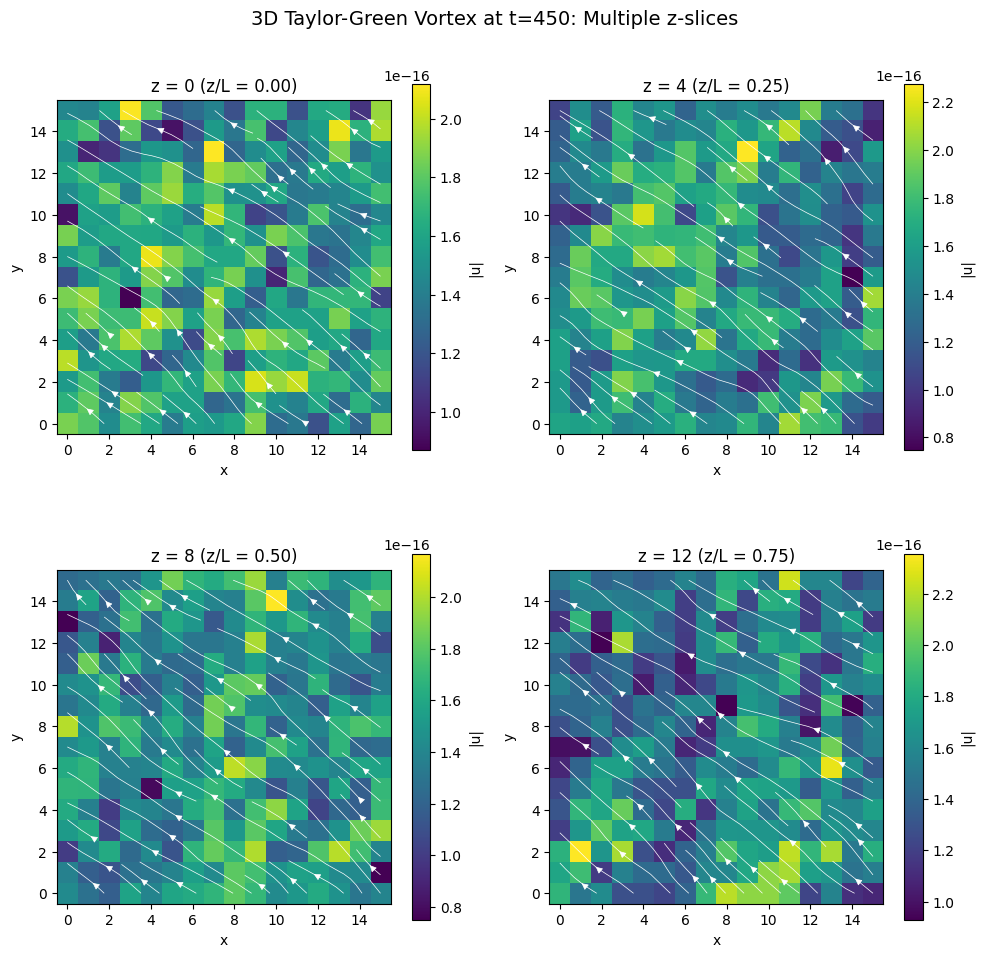


Velocity magnitude variation across z:
  z= 0: max|u|=0.0000, mean|u|=0.0000
  z= 4: max|u|=0.0000, mean|u|=0.0000
  z= 8: max|u|=0.0000, mean|u|=0.0000
  z=12: max|u|=0.0000, mean|u|=0.0000


In [11]:
###########################################################
# 3D Visualization: Multiple z-slices at final time
#
# Show slices at different z-levels to illustrate 3D structure
###########################################################

# Get final timestep data
t_final = tLst[-1]
ux_3d = dumpfile[dumpfile[:, 0] == t_final, 2].reshape((nx, ny, nz))
uy_3d = dumpfile[dumpfile[:, 0] == t_final, 3].reshape((nx, ny, nz))
uz_3d = dumpfile[dumpfile[:, 0] == t_final, 4].reshape((nx, ny, nz))

# Select z-slices to display
z_slices = [0, nz//4, nz//2, 3*nz//4]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for idx, z_idx in enumerate(z_slices):
    ax = axes[idx]
    
    # Extract slice
    ux_slice = ux_3d[:, :, z_idx]
    uy_slice = uy_3d[:, :, z_idx]
    u_mag = np.sqrt(ux_slice**2 + uy_slice**2)
    
    # Plot
    im = ax.imshow(u_mag.T, origin='lower', cmap='viridis')
    ax.streamplot(X.T, Y.T, ux_slice.T, uy_slice.T, density=0.6, color='white', linewidth=0.5)
    ax.set_title(f'z = {z_idx} (z/L = {z_idx/nz:.2f})', fontsize=12)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.colorbar(im, ax=ax, shrink=0.8, label='|u|')

fig.suptitle(f'3D Taylor-Green Vortex at t={int(t_final)}: Multiple z-slices', fontsize=14)
plt.tight_layout()
plt.show()

# Print z-variation summary
print(f"\nVelocity magnitude variation across z:")
for z_idx in z_slices:
    u_mag_slice = np.sqrt(ux_3d[:,:,z_idx]**2 + uy_3d[:,:,z_idx]**2 + uz_3d[:,:,z_idx]**2)
    print(f"  z={z_idx:2d}: max|u|={np.max(u_mag_slice):.4f}, mean|u|={np.mean(u_mag_slice):.4f}")